In [15]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import itertools

In [ ]:
# Create the combined Bayesian Network
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Sociodemographic Branch
# -----------------------------------------

# Independent nodes
gender = bn.add(gum.LabelizedVariable("Gender", "Gender of the person", 2))         # 0 = Male, 1 = Female
age = bn.add(gum.LabelizedVariable("Age", "Age category", 3))                       # 0 = Young, 1 = Middle, 2 = Old

# Nodes influenced by Age
marital = bn.add(gum.LabelizedVariable("MaritalStatus", "Marital status", 2))         # 0 = Single, 1 = Married
bn.addArc(age, marital)

econ = bn.add(gum.LabelizedVariable("Income", "Income", 3))      # 0 = Low, 1 = Medium, 2 = High
bn.addArc(age, econ)

# Aggregated SocioStatus [0 = Low, 1 = Medium, 2 = High]
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall sociodemographic status", 3))
bn.addArc(gender, socio)
bn.addArc(age, socio)
bn.addArc(marital, socio)
bn.addArc(econ, socio)

# -----------------------------------------
# Physical Health Branch
# -----------------------------------------

sleep = bn.add(gum.LabelizedVariable("SleepHabits", "Sleep Habits", 2))             # 0 = Good, 1 = Poor
chronic = bn.add(gum.LabelizedVariable("ChronicIllness", "Chronic Illness", 2))       # 0 = Absent, 1 = Present
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity", 2))                      # 0 = Not Obese, 1 = Obese

# Aggregated PhysicalHealth [0 = Good, 1 = Moderate, 2 = Poor]
physhealth = bn.add(gum.LabelizedVariable("PhysicalHealth", "Overall Physical Health", 3))
bn.addArc(sleep, physhealth)
bn.addArc(chronic, physhealth)
bn.addArc(obesity, physhealth)

# -----------------------------------------
# Additional Independent Nodes
# -----------------------------------------

# Genetic Predisposition (0 = Absent, 1 = Present)
genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", 2))
bn.cpt(genetic).fillWith([0.8, 0.2])  # e.g., 80% do not have a genetic predisposition

# Adverse Childhood Experiences (ACE) (0 = Absent, 1 = Present)
adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", 2))
bn.cpt(adverse).fillWith([0.7, 0.3])  # e.g., 70% report no ACE, 30% do

# -----------------------------------------
# Outcome Node: Depression Severity
# -----------------------------------------
# States: 0 = No Depression, 1 = Low, 2 = Medium, 3 = Severe
depress = bn.add(gum.LabelizedVariable("DepressionSeverity", "Severity of Depression", 4))
# DepressionSeverity is now influenced by SocioStatus, PhysicalHealth, GeneticPredisposition, and AdverseChildhood.
bn.addArc(socio, depress)
bn.addArc(physhealth, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)

# -----------------------------------------
# Setting Up the CPTs for the Other Nodes
# -----------------------------------------

# Sociodemographic branch
bn.cpt(gender).fillWith([0.4, 0.6])
bn.cpt(age).fillWith([0.2, 0.3, 0.5])
bn.cpt(marital).fillWith([
    0.9, 0.1,   # Age = 0 (Young)
    0.5, 0.5,   # Age = 1 (Middle)
    0.3, 0.7    # Age = 2 (Old)
])
bn.cpt(econ).fillWith([
    0.4, 0.4, 0.2,   # Age = 0
    0.3, 0.4, 0.3,   # Age = 1
    0.2, 0.3, 0.5    # Age = 2
])
# SocioStatus CPT (parents: Gender, Age, MaritalStatus, Income)
# Total combinations = 2 * 3 * 2 * 3 = 36 rows (illustrative values repeated for Gender = 0 and 1)
socio_rows = [
    # Gender = 0, Age = 0
    # MaritalStatus = Single:
    0.95, 0.04, 0.01,   # Econ = 0
    0.90, 0.07, 0.03,   # Econ = 1
    0.85, 0.10, 0.05,   # Econ = 2
    # MaritalStatus = Married:
    0.80, 0.15, 0.05,   # Econ = 0
    0.70, 0.20, 0.10,   # Econ = 1
    0.60, 0.25, 0.15,   # Econ = 2

    # Gender = 0, Age = 1
    # MaritalStatus = Single:
    0.60, 0.30, 0.10,   # Econ = 0
    0.50, 0.35, 0.15,   # Econ = 1
    0.40, 0.40, 0.20,   # Econ = 2
    # MaritalStatus = Married:
    0.40, 0.40, 0.20,   # Econ = 0
    0.30, 0.45, 0.25,   # Econ = 1
    0.20, 0.50, 0.30,   # Econ = 2

    # Gender = 0, Age = 2
    # MaritalStatus = Single:
    0.40, 0.40, 0.20,   # Econ = 0
    0.30, 0.45, 0.25,   # Econ = 1
    0.20, 0.50, 0.30,   # Econ = 2
    # MaritalStatus = Married:
    0.20, 0.40, 0.40,   # Econ = 0
    0.15, 0.35, 0.50,   # Econ = 1
    0.10, 0.30, 0.60,   # Econ = 2

    # Repeat for Gender = 1 (same 18 rows)
    0.95, 0.04, 0.01, 0.90, 0.07, 0.03, 0.85, 0.10, 0.05,
    0.80, 0.15, 0.05, 0.70, 0.20, 0.10, 0.60, 0.25, 0.15,
    0.60, 0.30, 0.10, 0.50, 0.35, 0.15, 0.40, 0.40, 0.20,
    0.40, 0.40, 0.20, 0.30, 0.45, 0.25, 0.20, 0.50, 0.30,
    0.40, 0.40, 0.20, 0.30, 0.45, 0.25, 0.20, 0.50, 0.30,
    0.20, 0.40, 0.40, 0.15, 0.35, 0.50, 0.10, 0.30, 0.60
]
bn.cpt(socio).fillWith(socio_rows)

# Physical Health branch
bn.cpt(sleep).fillWith([0.7, 0.3])
bn.cpt(chronic).fillWith([0.6, 0.4])
bn.cpt(obesity).fillWith([0.8, 0.2])
phys_rows = [
    0.90, 0.09, 0.01,  # Sleep=Good, Chronic=Absent, Obesity=Not Obese
    0.70, 0.20, 0.10,  # Sleep=Good, Chronic=Absent, Obesity=Obese
    0.60, 0.30, 0.10,  # Sleep=Good, Chronic=Present, Obesity=Not Obese
    0.40, 0.35, 0.25,  # Sleep=Good, Chronic=Present, Obesity=Obese
    0.70, 0.25, 0.05,  # Sleep=Poor, Chronic=Absent, Obesity=Not Obese
    0.50, 0.30, 0.20,  # Sleep=Poor, Chronic=Absent, Obesity=Obese
    0.40, 0.40, 0.20,  # Sleep=Poor, Chronic=Present, Obesity=Not Obese
    0.20, 0.40, 0.40   # Sleep=Poor, Chronic=Present, Obesity=Obese
]
bn.cpt(physhealth).fillWith(phys_rows)

# -----------------------------------------
# CPT for DepressionSeverity
# -----------------------------------------
# Parent ordering: [SocioStatus, PhysicalHealth, GeneticPredisposition, AdverseChildhood]
# There are 3 x 3 x 2 x 2 = 36 rows.
#
# For most combinations (except SocioStatus=High and PhysicalHealth=Good) the "No Depression"
# state is set to 0. For the special case (High, Good) a high probability is assigned to No Depression.
# Additionally, if GeneticPredisposition is true the "Severe" probability is multiplied by ~1.5;
# if AdverseChildhood is present the severe outcome is further multiplied by ~1.3,
# with renormalization applied.
#
# The following list of 36 rows is provided in blocks.
#
# Block ordering by (SocioStatus, PhysicalHealth):
# 1. (Low, Good)
# 2. (Low, Moderate)
# 3. (Low, Poor)
# 4. (Medium, Good)
# 5. (Medium, Moderate)
# 6. (Medium, Poor)
# 7. (High, Good) [special case]
# 8. (High, Moderate)
# 9. (High, Poor)
#
# Within each block the ordering is: for GeneticPredisposition = 0 then 1,
# and for each, AdverseChildhood = 0 then 1.
depr_rows = [
    # Block 1: SocioStatus = Low, PhysicalHealth = Good
    # GP=0, ACE=0:
    0.00, 0.60, 0.30, 0.10,
    # GP=0, ACE=1: (Severe: 0.10x1.3 -> 0.13, total=1.03) -> [0.00, 0.58, 0.29, 0.13]
    0.00, 0.58, 0.29, 0.13,
    # GP=1, ACE=0: (Severe: 0.14x1.0) -> [0.00, 0.57, 0.29, 0.14]
    0.00, 0.57, 0.29, 0.14,
    # GP=1, ACE=1: (Severe: 0.14x1.3 -> 0.182, total~1.042) -> [0.00, 0.55, 0.28, 0.18]
    0.00, 0.55, 0.28, 0.18,
    
    # Block 2: SocioStatus = Low, PhysicalHealth = Moderate
    # GP=0, ACE=0:
    0.00, 0.40, 0.40, 0.20,
    # GP=0, ACE=1: (0.20 -> 0.26; normalized ~[0.00,0.38,0.38,0.24])
    0.00, 0.38, 0.38, 0.24,
    # GP=1, ACE=0:
    0.00, 0.36, 0.36, 0.27,
    # GP=1, ACE=1: (0.27->0.351; normalized ~[0.00,0.34,0.34,0.33])
    0.00, 0.34, 0.34, 0.33,
    
    # Block 3: SocioStatus = Low, PhysicalHealth = Poor
    # GP=0, ACE=0:
    0.00, 0.20, 0.40, 0.40,
    # GP=0, ACE=1: (0.40->0.52; normalized ~[0.00,0.18,0.36,0.46])
    0.00, 0.18, 0.36, 0.46,
    # GP=1, ACE=0:
    0.00, 0.17, 0.33, 0.50,
    # GP=1, ACE=1: (0.50->0.65; normalized ~[0.00,0.15,0.29,0.57])
    0.00, 0.15, 0.29, 0.57,
    
    # Block 4: SocioStatus = Medium, PhysicalHealth = Good
    # GP=0, ACE=0:
    0.00, 0.70, 0.25, 0.05,
    # GP=0, ACE=1: (0.05->0.065; normalized ~[0.00,0.69,0.25,0.06])
    0.00, 0.69, 0.25, 0.06,
    # GP=1, ACE=0:
    0.00, 0.68, 0.24, 0.07,
    # GP=1, ACE=1: (0.07->0.091; normalized ~[0.00,0.67,0.24,0.09])
    0.00, 0.67, 0.24, 0.09,
    
    # Block 5: SocioStatus = Medium, PhysicalHealth = Moderate
    # GP=0, ACE=0:
    0.00, 0.50, 0.35, 0.15,
    # GP=0, ACE=1: (0.15->0.195; normalized ~[0.00,0.48,0.34,0.19])
    0.00, 0.48, 0.34, 0.19,
    # GP=1, ACE=0:
    0.00, 0.47, 0.33, 0.21,
    # GP=1, ACE=1: (0.21->0.273; normalized ~[0.00,0.44,0.31,0.26])
    0.00, 0.44, 0.31, 0.26,
    
    # Block 6: SocioStatus = Medium, PhysicalHealth = Poor
    # GP=0, ACE=0:
    0.00, 0.30, 0.40, 0.30,
    # GP=0, ACE=1: (0.30->0.39; normalized ~[0.00,0.28,0.37,0.36])
    0.00, 0.28, 0.37, 0.36,
    # GP=1, ACE=0:
    0.00, 0.26, 0.35, 0.39,
    # GP=1, ACE=1: (0.39->0.507; normalized ~[0.00,0.23,0.31,0.45])
    0.00, 0.23, 0.31, 0.45,
    
    # Block 7: SocioStatus = High, PhysicalHealth = Good (special case)
    # GP=0, ACE=0:
    0.85, 0.10, 0.04, 0.01,
    # GP=0, ACE=1: (Severe: 0.01->0.013; normalized nearly the same) 
    0.85, 0.10, 0.04, 0.013,
    # GP=1, ACE=0:
    0.70, 0.15, 0.10, 0.05,
    # GP=1, ACE=1: (0.05->0.065; normalized ~[0.69,0.15,0.10,0.06])
    0.69, 0.15, 0.10, 0.06,
    
    # Block 8: SocioStatus = High, PhysicalHealth = Moderate
    # GP=0, ACE=0:
    0.00, 0.60, 0.30, 0.10,
    # GP=0, ACE=1: (0.10->0.13; normalized ~[0.00,0.58,0.29,0.13])
    0.00, 0.58, 0.29, 0.13,
    # GP=1, ACE=0:
    0.00, 0.57, 0.29, 0.14,
    # GP=1, ACE=1: (0.14->0.182; normalized ~[0.00,0.55,0.28,0.18])
    0.00, 0.55, 0.28, 0.18,
    
    # Block 9: SocioStatus = High, PhysicalHealth = Poor
    # GP=0, ACE=0:
    0.00, 0.40, 0.35, 0.25,
    # GP=0, ACE=1: (0.25->0.325; normalized ~[0.00,0.37,0.33,0.30])
    0.00, 0.37, 0.33, 0.30,
    # GP=1, ACE=0:
    0.00, 0.36, 0.31, 0.33,
    # GP=1, ACE=1: (0.33->0.429; normalized ~[0.00,0.33,0.28,0.39])
    0.00, 0.33, 0.28, 0.39,
]
bn.cpt(depress).fillWith(depr_rows)

# -----------------------------------------
# Display the Combined Network and Perform Inference
# -----------------------------------------

print("Combined Bayesian Network structure for Depression Severity (with Genetic Predisposition, ACE, and a No Depression case):")
print(bn)

# Set up the inference engine
ie = gum.LazyPropagation(bn)

# Example evidence:
# - Sociodemographic info: Gender = Female (1), Age = Middle (1) [MaritalStatus and Income follow from Age]
# - Physical Health: Poor sleep (SleepHabits = 1), Chronic Illness = Present (1), Obesity = Present (1)
# - Genetic Predisposition: Present (1)
# - Adverse Childhood Experiences: Present (1)
evidence = {
    'Gender': 1,
    'Age': 1,
    'SleepHabits': 1,
    'ChronicIllness': 1,
    'Obesity': 1,
    'GeneticPredisposition': 1,
    'AdverseChildhood': 1
}
ie.setEvidence(evidence)
ie.makeInference()

posterior_depress = ie.posterior(depress)
print("\nPosterior probabilities for DepressionSeverity given the evidence:")
print(posterior_depress)


Combined Bayesian Network structure for Depression Severity (with Genetic Predisposition, ACE, and a No Depression case):
BN{nodes: 12, arcs: 13, domainSize: 41472, dim: 213, mem: 2Ko 400o}

Posterior probabilities for DepressionSeverity given the evidence:

  DepressionSeverity                   |
0        |1        |2        |3        |
---------|---------|---------|---------|
 0.0648  | 0.4303  | 0.2855  | 0.2194  |



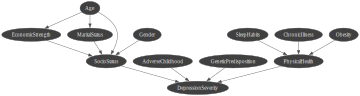

In [17]:
gnb.show(bn)

In [18]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Gender:


Statistics for Age:


Statistics for MaritalStatus:


Statistics for EconomicStrength:


Statistics for SocioStatus:


Statistics for SleepHabits:


Statistics for ChronicIllness:


Statistics for Obesity:


Statistics for PhysicalHealth:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for DepressionSeverity:


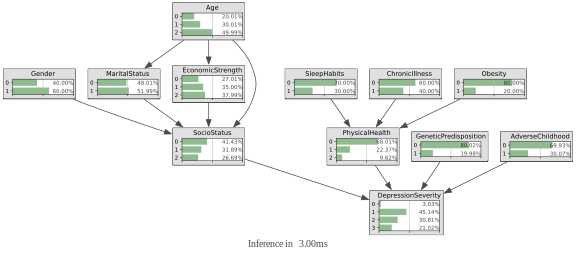

In [19]:
# Use bn (the BayesNet) as the model and pass the inference engine with the 'engine' keyword.
gnb.showInference(bn, engine=ie)
